# Consensus clustering and consistency


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import igraph
import leidenalg
import numpy as np
import itertools
import pandas as pd
from nwtools import communities, consensus

In [2]:
g_test = igraph.Graph(directed=False)
node_names = [str(c) for c in range(1, 14)]
print(node_names)
g_test.add_vertices(node_names)


edges = [
    (1,2),
    (1,3),
    (2,3),
    (2,4),
    (2,5),
    (3,4),
    (3,5),
    (4,5),
    (4,6),
    (4,8),
    (5,8),
    (6,7),
    (7,10),
    (8,9),
    (8,10),
    (9, 10),
    (9, 11),
    (9, 13),
    (10, 11),
    (10, 12),
    (11, 12),
    (11, 13),
    (12, 13)
]
g_test.add_edges([(str(s), str(t)) for s,t in edges])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


In [3]:
layout_x = (0, 1, 1, 2, 2, 3, 4, 3, 5, 5, 6, 7, 7)
layout_y = (2, 1, 3, 1, 3, 0, 0, 2, 3, 1, 2, 1, 3)
layout = list(zip(layout_x, layout_y))

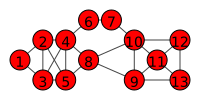

In [4]:
#layout = g_test.layout('kk')
igraph.plot(g_test, layout=layout, 
            #vertex_color = [color_dict[c] for c in part1.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

In [69]:
partitions = consensus.get_initial_partitions(g_test)

Iteration 0
Smallest connected component: 2
Iteration 1
Smallest connected component: 2
Converged!


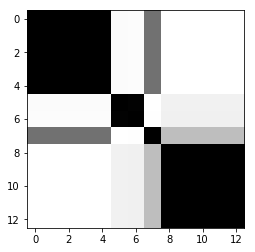

In [72]:
consensus_matrix, consensus_membership = consensus.consensus_partition(g_test, initial_partition=partitions,
                        nr_partitions=len(partitions),
                        threshold=0.5,
                        verbose=True)
plt.imshow(consensus_matrix, cmap='Greys')

In [73]:
from sklearn.metrics.cluster import normalized_mutual_info_score

def get_unique_partitions(partitions):
    memberships = [p.membership for p in partitions]
    nmi_all = np.array([[normalized_mutual_info_score(mem1, mem2, average_method='geometric') 
                     for mem1 in memberships] for mem2 in memberships])
    partitions_same = 1*(nmi_all==1)
    g_partitions = igraph.Graph.Adjacency(partitions_same.tolist())
    ccs = g_partitions.clusters().membership
    unique_part_index = [np.nonzero(np.array(ccs)==i)[0] for i in set(ccs)]
    unique_part_counts = [len(a) for a in unique_part_index]
    unique_partitions = [partitions[i[0]] for i in unique_part_index]
    return nmi_all, unique_partitions, unique_part_counts

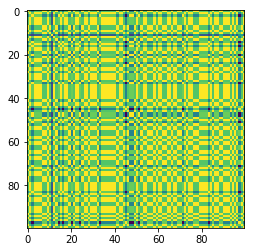

In [76]:
nmi_all, unique_partitions, unique_part_counts = get_unique_partitions(partitions)
plt.imshow(nmi_all)

In [77]:
print(unique_part_counts)

[2, 1, 11, 52, 34]


In [78]:
part1, part2, part3, part4, part5 = unique_partitions

n1, n2, n3, n4, n5 = unique_part_counts

initial_partition = partitions

In [79]:
color_dict = {0: 'lightblue', 1: 'green', 2: 'red'}

In [80]:
def get_modularity(part, graph):
    return leidenalg.ModularityVertexPartition(graph, initial_membership=part.membership 
                                                 #, weights='weight'
                                              ).quality()

consensus partition, modularity: 0.40


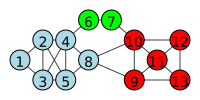

In [83]:
print('consensus partition, modularity: {:.2f}'.format(leidenalg.ModularityVertexPartition(g_test, initial_membership=consensus_membership).quality()))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in consensus_membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

2 partitions, modularity: 0.37


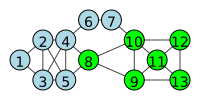

In [84]:
print('{} partitions, modularity: {:.2f}'.format(n1, get_modularity(part1, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part1.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

1 partitions, modularity: 0.37


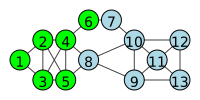

In [85]:
print('{} partitions, modularity: {:.2f}'.format(n2, get_modularity(part2, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part2.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

11 partitions, modularity: 0.37


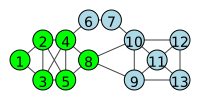

In [86]:
print('{} partitions, modularity: {:.2f}'.format(n3, get_modularity(part3, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part3.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

52 partitions, modularity: 0.40


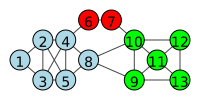

In [87]:
print('{} partitions, modularity: {:.2f}'.format(n4, get_modularity(part4, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part4.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

34 partitions, modularity: 0.40


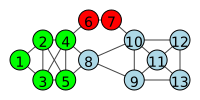

In [88]:
print('{} partitions, modularity: {:.2f}'.format(n5, get_modularity(part5, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part5.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

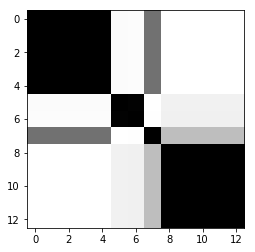

In [89]:
consensus_mat = consensus.get_consensus_matrix(initial_partition, g_test.vcount())
plt.imshow(consensus_mat, cmap='Greys')
#plt.xticks.l(node_names)

In [90]:
def get_edge_consistency(graph, consensus_matrix):
    edge_indices = [e.tuple for e in graph.es]
    ix, jx = zip(*edge_indices)
    graph.es['consensus'] = consensus_matrix[ix, jx]
    graph.es['consistency'] = 2*np.abs(np.array(graph.es['consensus'])-0.5)
    return graph

In [91]:
g_test = get_edge_consistency(g_test, consensus_mat)

In [92]:
consensus_df = pd.DataFrame({'Source': [node_names[e.source] for e in g_test.es],
                             'Target': [node_names[e.target] for e in g_test.es],
                            'consensus': g_test.es['consensus'],
                            'consistency': g_test.es['consistency']})

In [161]:
consensus_df['consistency_squared'] = np.square(1 - 2*consensus_df.consensus)

In [162]:
consensus_df

,Source,Target,consensus,consistency,reference_dif,reference_consistency,consistency_squared
0,1,2,1.00,1.00,0.00,1.00,1.0000
1,1,3,1.00,1.00,0.00,1.00,1.0000
2,2,3,1.00,1.00,0.00,1.00,1.0000
3,2,4,1.00,1.00,0.00,1.00,1.0000
4,2,5,1.00,1.00,0.00,1.00,1.0000
5,3,4,1.00,1.00,0.00,1.00,1.0000
6,3,5,1.00,1.00,0.00,1.00,1.0000
7,4,5,1.00,1.00,0.00,1.00,1.0000
8,4,6,0.03,0.94,-0.03,0.97,0.8836
9,4,8,0.63,0.26,0.37,0.63,0.0676


In [94]:
# Which possible thresholds do we have?
cutoffs = sorted(consensus_df.consistency.unique())
print(cutoffs)
thresholds = cutoffs[1:]

[0.26, 0.76, 0.94, 0.98, 1.0]


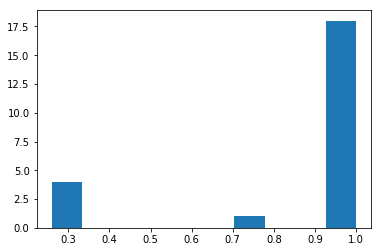

In [95]:
plt.hist(consensus_df.consistency)
plt.show()

Look at consistency compared to reference clustering, e.g. the consensus clustering

In [136]:
reference_part = igraph.clustering.VertexClustering(g_test, consensus_membership)

In [133]:
gain, penalty, contribution = consensus.modularity_contribution(g_test, part1.membership)

In [134]:
pd.DataFrame({'gain': gain, 'penalty': penalty, 'contribution': contribution}, index=node_names)

,gain,penalty,contribution
1,0.086957,-0.041588,0.128544
2,0.173913,-0.079395,0.253308
3,0.173913,-0.079395,0.253308
4,0.173913,-0.096881,0.270794
5,0.130435,-0.079395,0.209830
6,0.086957,-0.041588,0.128544
7,0.043478,-0.041588,0.085066
8,0.086957,-0.079395,0.166352
9,0.173913,-0.079395,0.253308
10,0.173913,-0.096881,0.270794


In [137]:
ref_mat = consensus.get_consensus_matrix([reference_part], g_test.vcount())
consensus_within_cluster = ref_mat*consensus_mat
np.fill_diagonal(consensus_within_cluster, 0)
node_consistency_within_cluster = np.sum(consensus_within_cluster, axis=0) / np.sum(consensus_within_cluster>0, axis=0) # This is the mean over all non-zero values per row

In [138]:
g_test.vs['reference_consistency'] = node_consistency_within_cluster

In [139]:
def reference_consistency(reference_part, graph):
    ref_mat = consensus.get_consensus_matrix([reference_part], graph.vcount())
    reference_dif_mat = ref_mat - consensus_mat
    
    edge_indices = [e.tuple for e in graph.es]
    ix, jx = zip(*edge_indices)
    
    reference_dif = reference_dif_mat[ix, jx]
    reference_consistency = 1 - np.abs(np.array(reference_dif))
    return reference_dif, reference_consistency 

In [140]:
reference_dif, reference_consistency = reference_consistency(reference_part, g_test)

In [141]:

g_test.es['reference_dif'] = reference_dif
g_test.es['reference_consistency'] = reference_consistency
consensus_df['reference_dif'] = reference_dif
consensus_df['reference_consistency'] = reference_consistency

In [142]:
consensus_df

,Source,Target,consensus,consistency,reference_dif,reference_consistency
0,1,2,1.00,1.00,0.00,1.00
1,1,3,1.00,1.00,0.00,1.00
2,2,3,1.00,1.00,0.00,1.00
3,2,4,1.00,1.00,0.00,1.00
4,2,5,1.00,1.00,0.00,1.00
5,3,4,1.00,1.00,0.00,1.00
6,3,5,1.00,1.00,0.00,1.00
7,4,5,1.00,1.00,0.00,1.00
8,4,6,0.03,0.94,-0.03,0.97
9,4,8,0.63,0.26,0.37,0.63


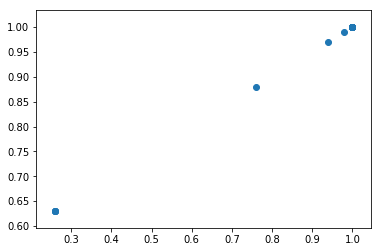

In [143]:
plt.scatter(consensus_df.consistency, consensus_df.reference_consistency)

In [144]:
def get_node_stability(graph, edges_df, thres_list=None):
    suffix = ''
    names = graph.vs.get_attribute_values('name')
    nodes_df = pd.DataFrame(index=names)
    nodes_df['degree'+suffix] = pd.Series(graph.degree(), index=names)
    #nodes_df['weighted_degree'+suffix] = pd.Series(graph.strength(weights='weight'), index=names)
    nodes_df['eigenvector_centrality'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False), index=names)
    nodes_df['betweenness'+suffix] = pd.Series(graph.betweenness(directed=False), index=names)
    edges_unstacked = edges_df.consistency.unstack()
    
    stabilities_unstacked = edges_unstacked.add(edges_unstacked.transpose(), fill_value=0)

    nodes_df['consistency_mean'] = stabilities_unstacked.mean(axis=0)
    nodes_df['consistency_min'] = stabilities_unstacked.min(axis=0)
    nodes_df['consistency_max'] = stabilities_unstacked.max(axis=0)
    nodes_df['consistency_std'] = stabilities_unstacked.apply(np.std, axis=0)
    nodes_df['consistency_mean_min_std'] = nodes_df['consistency_mean'] - nodes_df['consistency_std']
    if thres_list is None:
        thres_list = [0.8, 0.9, 1.0]
    for thres in thres_list:
        perc_consistent_neigbors =  (stabilities_unstacked>=thres).sum(axis=0) / (~stabilities_unstacked.isna()).sum(axis=0)
        nodes_df['consistency_neighbors_{:.2f}'.format(thres)] =perc_consistent_neigbors
        
    return nodes_df

In [145]:
node_consistency = get_node_stability(g_test, consensus_df.set_index(['Source', 'Target']),
                                     thres_list=thresholds)#[0.5, 0.65, 1])

In [146]:
reference_dif_mat = ref_mat - consensus_mat
node_consistency['ref_consistency_mean_all'] = np.mean(1-np.abs(reference_dif_mat), axis=1)

In [147]:
node_consistency['gain'] = gain
node_consistency['penalty'] = penalty
node_consistency['contribution'] = contribution

In [148]:
node_consistency['reference_consistency'] = node_consistency_within_cluster

In [149]:
node_consistency

,degree,eigenvector_centrality,betweenness,consistency_mean,consistency_min,consistency_max,consistency_std,consistency_mean_min_std,consistency_neighbors_0.76,consistency_neighbors_0.94,consistency_neighbors_0.98,consistency_neighbors_1.00,ref_consistency_mean_all,gain,penalty,contribution,reference_consistency
1,2,0.431123,0.000000,1.000,1.00,1.00,0.000000,1.000000,1.00,1.00,1.00,1.00,0.967692,0.086957,-0.041588,0.128544,0.926
2,4,0.829294,5.000000,1.000,1.00,1.00,0.000000,1.000000,1.00,1.00,1.00,1.00,0.967692,0.173913,-0.079395,0.253308,0.926
3,4,0.829294,5.000000,1.000,1.00,1.00,0.000000,1.000000,1.00,1.00,1.00,1.00,0.967692,0.173913,-0.079395,0.253308,0.926
4,5,1.000000,18.250000,0.840,0.26,1.00,0.290930,0.549070,0.80,0.80,0.60,0.60,0.967692,0.173913,-0.096881,0.270794,0.926
5,4,0.929989,9.000000,0.815,0.26,1.00,0.320429,0.494571,0.75,0.75,0.75,0.75,0.967692,0.130435,-0.079395,0.209830,0.926
6,2,0.339352,4.500000,0.960,0.94,0.98,0.020000,0.940000,1.00,1.00,0.50,0.00,0.945385,0.086957,-0.041588,0.128544,0.990
7,2,0.305535,4.250000,0.870,0.76,0.98,0.110000,0.760000,1.00,0.50,0.50,0.00,0.944615,0.043478,-0.041588,0.085066,0.990
8,4,0.919207,26.250000,0.260,0.26,0.26,0.000000,0.260000,0.00,0.00,0.00,0.00,0.714615,0.086957,-0.079395,0.166352,0.630
9,4,0.770245,10.166667,0.815,0.26,1.00,0.320429,0.494571,0.75,0.75,0.75,0.75,0.953846,0.173913,-0.079395,0.253308,1.000
10,5,0.836082,18.083333,0.804,0.26,1.00,0.287444,0.516556,0.80,0.60,0.60,0.60,0.953846,0.173913,-0.096881,0.270794,1.000


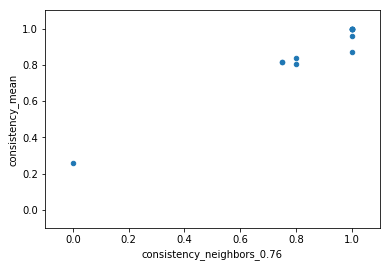

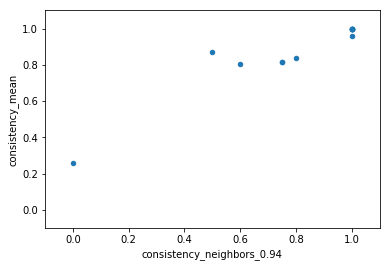

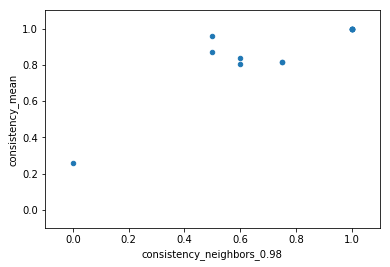

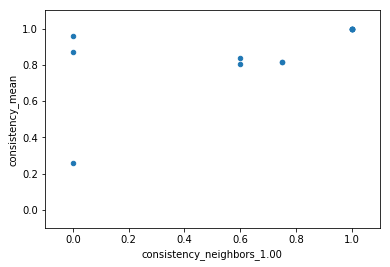

In [150]:
for t in thresholds:
    node_consistency.plot('consistency_neighbors_{:.2f}'.format(t), 'consistency_mean', kind='scatter')
    plt.xlim(-.1,1.1)
    plt.ylim(-.1,1.1)

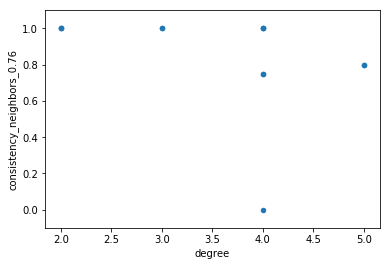

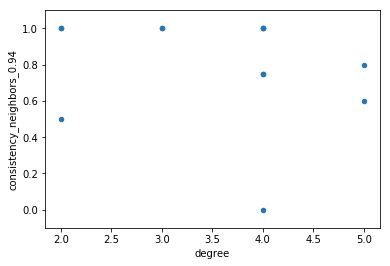

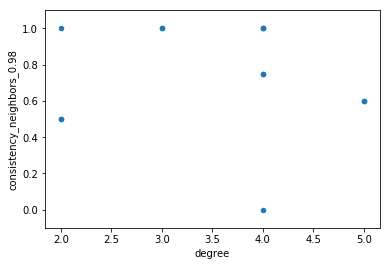

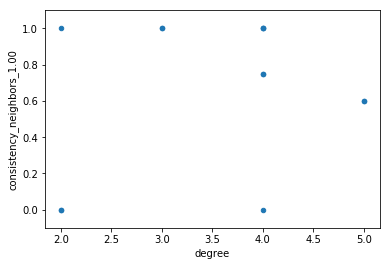

In [151]:
for t in thresholds:
    node_consistency.plot('degree', 'consistency_neighbors_{:.2f}'.format(t), kind='scatter')
    plt.ylim(-.1,1.1)

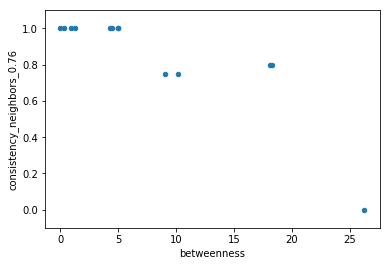

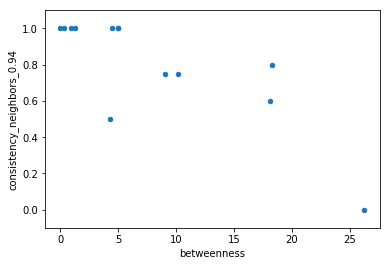

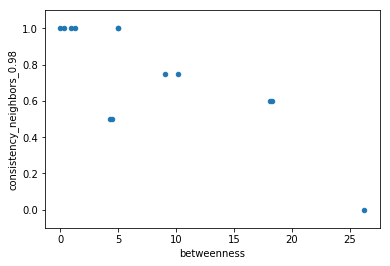

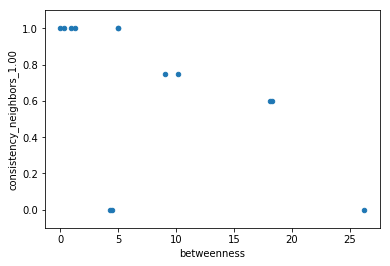

In [152]:
for t in thresholds:
    node_consistency.plot('betweenness', 'consistency_neighbors_{:.2f}'.format(t), kind='scatter')
    plt.ylim(-.1,1.1)

(-0.1, 1.1)

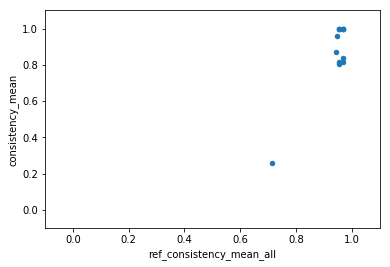

In [153]:
node_consistency.plot('ref_consistency_mean_all', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

In [154]:
n = g_test.vcount()
b_min = min(node_consistency['betweenness'])
b_max = max(node_consistency['betweenness'])
node_consistency['betweenness_normalized'] = (node_consistency['betweenness'] - b_min) / (b_max - b_min) #* 2/((n-1)*(n-2))

In [155]:
import matplotlib 
cm = matplotlib.cm.get_cmap('Greens')

In [156]:
node_consistency['betweenness_normalized']

1     0.000000
2     0.190476
3     0.190476
4     0.695238
5     0.342857
6     0.171429
7     0.161905
8     1.000000
9     0.387302
10    0.688889
11    0.047619
12    0.034921
13    0.012698
Name: betweenness_normalized, dtype: float64

In [157]:
node_consistency.columns

Index(['degree', 'eigenvector_centrality', 'betweenness', 'consistency_mean',
       'consistency_min', 'consistency_max', 'consistency_std',
       'consistency_mean_min_std', 'consistency_neighbors_0.76',
       'consistency_neighbors_0.94', 'consistency_neighbors_0.98',
       'consistency_neighbors_1.00', 'ref_consistency_mean_all', 'gain',
       'penalty', 'contribution', 'reference_consistency',
       'betweenness_normalized'],
      dtype='object')

degree


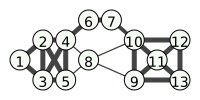

eigenvector_centrality


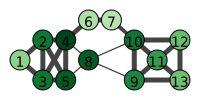

betweenness


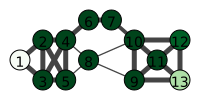

consistency_mean


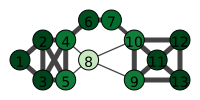

consistency_min


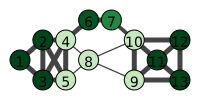

consistency_max


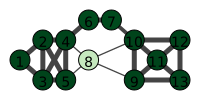

consistency_std


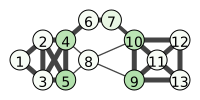

consistency_mean_min_std


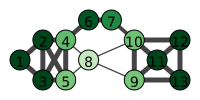

consistency_neighbors_0.76


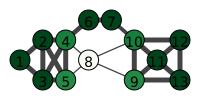

consistency_neighbors_0.94


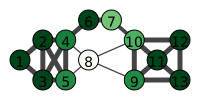

consistency_neighbors_0.98


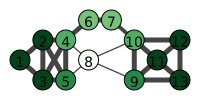

consistency_neighbors_1.00


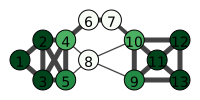

ref_consistency_mean_all


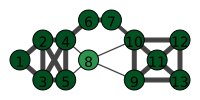

gain


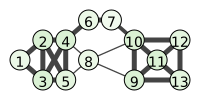

penalty


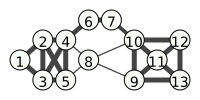

contribution


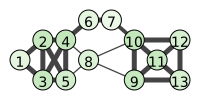

reference_consistency


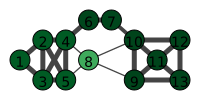

betweenness_normalized


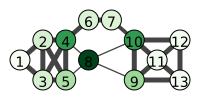

In [158]:
from IPython.core.display import display, SVG
for att in node_consistency.columns:
    print(att)
    display(SVG(igraph.plot(g_test, layout=layout, 
                vertex_color = [cm(c) for c in node_consistency[att]],
                edge_width = 5*consensus_df.consistency,
                vertex_label = g_test.vs["name"],
               bbox=(0,0,200,100))._repr_svg_()))